In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [63]:
session_info = {'date': "26_04_2024",
                'genotype_dir': "ER4d_iGABASnFR2_Chrimson88tdT",
                'fly': 'fly1',
                'session': 'baseline-002',
                'full_genotype': '',
                'ecl date': '',
                'notes': ''}

bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
fictrac_folder = pathlib.PurePath('/media/mplitt/SSD_storage/fictrac_folder')
                            

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_base_dir = fictrac_folder)


In [3]:
pp.extract_metadata()
pp.bruker_to_h5(overwrite=False,first_chan=1)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)



In [4]:
nap = pp.open_napari()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


In [5]:
print()

In [6]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)
# y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)
y_or = pp.calculate_zscored_F('outer_ring', exp_detrend=True,zscore=False)

In [7]:
pp.save()

In [64]:
if True:
    n_rois=16
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
   

In [65]:


# y = pp.calculate_zscored_F('rois', exp_detrend=True,zscore=False)[1,:,:]
y_or = pp.calculate_zscored_F('outer_ring', exp_detrend=True,zscore=False)[1,0,:]-1
# y_or = sp.ndimage.median_filter(y_or,3)
# y = y[1,:,:]/y[0,:,:]
print(y_or.shape)
y_or[y_or>5]=1
# y= sp.ndimage.gaussian_filter1d(sp.ndimage.median_filter(y,(1,3)),3,axis=-1)

(1638,)


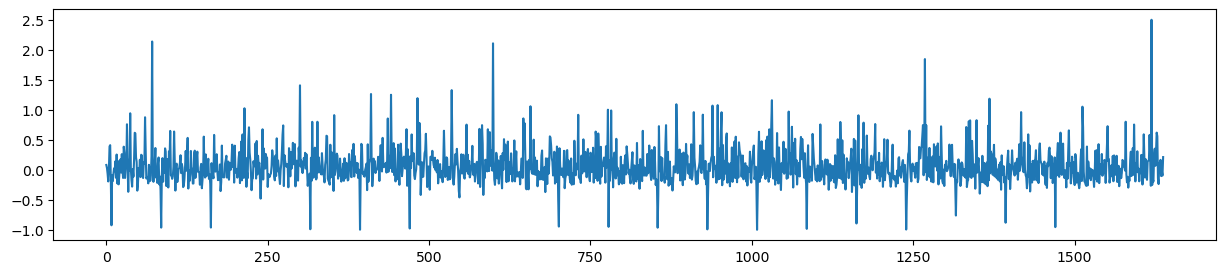

In [66]:
# fig, ax = plt.subplots()
# ax.imshow(y,aspect='auto')

fig, ax = plt.subplots(figsize = [ 15,3])
ax.plot(y_or.ravel())

In [67]:
# fig, ax = plt.subplots(figsize= [15,9])
# # x = pp.voltage_recording_aligned['Time(ms)'].to_numpy()
# for r in range(n_rois):
#     ax.plot(y[r,:]+r)

In [68]:
frame_times = np.array(pp.metadata['frame_times']).mean(axis=1)

In [69]:
print(frame_times)

[6.41268400e-02 1.92380520e-01 3.20634200e-01 ... 2.09758894e+02
 2.09887147e+02 2.10015401e+02]


In [70]:
dt = (frame_times[1:]-frame_times[:-1]).mean()

In [71]:
pp.metadata['mark_points']['repetitions']

20

In [72]:
stim_times = [pp.metadata['mark_points']['initial_delay']]
for i in range(pp.metadata['mark_points']['repetitions']-1):
    stim_times.append(pp.metadata['mark_points']['inter_point_delay']+pp.metadata['mark_points']['duration'])
stim_times = np.array(stim_times)/1000
stim_times = np.cumsum(stim_times)
print(stim_times)

[  1.       10.86819  20.73638  30.60457  40.47276  50.34095  60.20914
  70.07733  79.94552  89.81371  99.6819  109.55009 119.41828 129.28647
 139.15466 149.02285 158.89104 168.75923 178.62742 188.49561]


In [73]:
stim_inds = []
for time in stim_times:
    stim_inds.append( np.argwhere((frame_times-time)>0)[0][0])
stim_inds = np.array(stim_inds)

In [74]:
for ind in stim_inds:
    y_or[ind-1:ind+1] = np.nan
# y_or[ stim_inds]=np.nan
# y_or[stim_inds-2]=np.nan

# y_or[ stim_inds+3]=np.nan

In [75]:
stim_resp = np.zeros((len(stim_inds), 80))
for i, ind in enumerate(stim_inds[1:]):
    print(i)
    stim_resp[i,:] = y_or[ind-10:ind+70]
stim_resp -= np.nanmean(stim_resp[:,:10], axis=-1, keepdims=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


Text(0.5, 1.0, 'sytjGCaMP7f (50 microM Picrotoxin, 25 microM curare)')

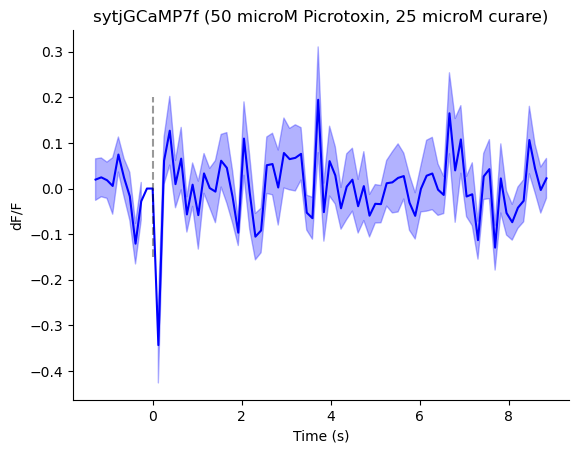

In [76]:
fig, ax= plt.subplots()
mu = np.nanmean(stim_resp[:,:],axis=0)
sem = sp.stats.sem(stim_resp,axis=0, nan_policy='omit')

x = np.arange(-10*dt, 69*dt+1E-3, dt) 
ax.plot(x, mu, color='blue')
ax.fill_between(x, mu-sem, mu+sem, color='blue', alpha=.3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('dF/F')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.plot([0,0],[-.15,.2], 'k--',alpha=.4)
ax.set_title('sytjGCaMP7f (50 microM Picrotoxin, 25 microM curare)')


# figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_meetings/ER4d_iGABASnFR2_Chrimson88tdT/')
# figfolder.mkdir(parents=True, exist_ok=True)
# fig.savefig(figfolder / "example_stim.pdf")

(20, 80)
-0.07969924812030074 0.73837374901493


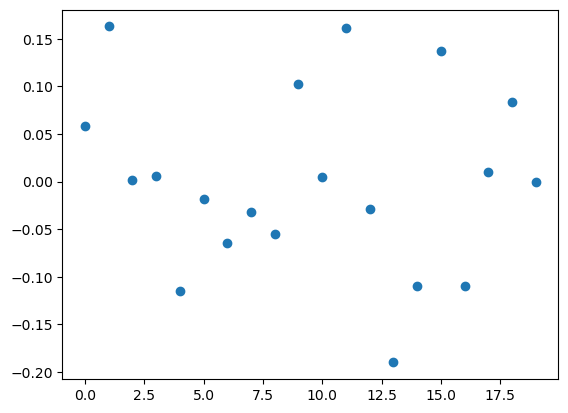

In [77]:
# for i in range(stim_resp.shape[0]):
#     fig, ax= plt.subplots()
#     ax.plot(x, stim_resp[i,:,:].mean(axis=0))
print(stim_resp.shape)
fig,ax = plt.subplots()
ax.scatter(np.arange(20), stim_resp[:,14:20].mean(axis=-1))
r,p = sp.stats.spearmanr(np.arange(20),stim_resp[:,14:20].mean(axis=-1))
print(r,p)

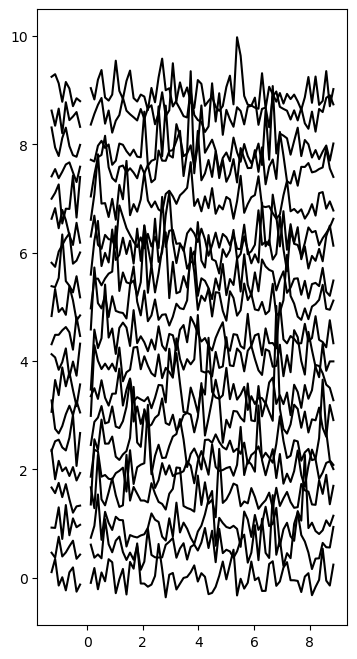

In [78]:
fig, ax= plt.subplots(figsize=[4,8])
for i in range(19):
    ax.plot(x, stim_resp[i, :] +i/2, color='black')
# ax.plot(x,stim_resp.T) #, vmin=-.02, vmax=.15)

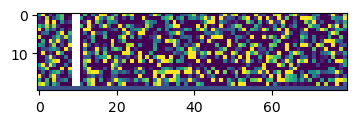

In [79]:
fig, ax= plt.subplots(figsize=[4,8])
ax.imshow(stim_resp, vmin=-.1, vmax=.3)